In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the datasets
train_data = pd.read_csv('C:\\Users\\91913\\Downloads\\archive (7)\\Weather Training Data.csv')
test_data = pd.read_csv('C:\\Users\\91913\\Downloads\\archive (7)\\Weather Test Data.csv')

# Display the first few rows of the training and test data
train_data.head()

,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0


In [5]:
# Drop the 'row ID' column as it is not needed for analysis
train_data = train_data.drop('row ID', axis=1)
test_data = test_data.drop('row ID', axis=1)

# Drop rows with empty cells in the training data
train_data = train_data.dropna()
test_data = test_data.dropna()

# Check for missing values in the training data
missing_values = train_data.isnull().sum()
print(missing_values)

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


In [6]:
# Display information about the training and test data
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39574 entries, 4183 to 97410
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       39574 non-null  object 
 1   MinTemp        39574 non-null  float64
 2   MaxTemp        39574 non-null  float64
 3   Rainfall       39574 non-null  float64
 4   Evaporation    39574 non-null  float64
 5   Sunshine       39574 non-null  float64
 6   WindGustDir    39574 non-null  object 
 7   WindGustSpeed  39574 non-null  float64
 8   WindDir9am     39574 non-null  object 
 9   WindDir3pm     39574 non-null  object 
 10  WindSpeed9am   39574 non-null  float64
 11  WindSpeed3pm   39574 non-null  float64
 12  Humidity9am    39574 non-null  float64
 13  Humidity3pm    39574 non-null  float64
 14  Pressure9am    39574 non-null  float64
 15  Pressure3pm    39574 non-null  float64
 16  Cloud9am       39574 non-null  float64
 17  Cloud3pm       39574 non-null  float64
 18  Tem

In [7]:
# Identify categorical and numerical columns in the training data
categorical_cols = train_data.select_dtypes(include=['object']).columns
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns

In [8]:
# Display summary statistics for the numerical columns
train_data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
count,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000,39574.000000
mean,13.461414,24.211985,2.163137,5.495004,7.723311,40.891115,15.689518,19.794360,65.870622,49.565548,1017.265985,1014.821302,4.256052,4.343812,18.196958,22.705092,0.222419
std,6.389018,6.965980,7.025190,3.697796,3.757568,13.316400,8.327292,8.531193,18.553322,20.185655,6.929267,6.894293,2.798105,2.644123,6.549293,6.829223,0.415876
min,-6.700000,7.000000,0.000000,0.000000,0.000000,11.000000,2.000000,2.000000,0.000000,0.000000,980.500000,978.200000,0.000000,0.000000,-0.700000,4.300000,0.000000
25%,8.600000,18.700000,0.000000,2.800000,5.000000,31.000000,9.000000,13.000000,55.000000,35.000000,1012.700000,1010.100000,1.000000,2.000000,13.100000,17.400000,0.000000
50%,13.200000,23.900000,0.000000,5.000000,8.600000,39.000000,15.000000,19.000000,67.000000,50.000000,1017.200000,1014.700000,5.000000,5.000000,17.700000,22.400000,0.000000
75%,18.400000,29.700000,0.600000,7.400000,10.700000,48.000000,20.000000,26.000000,79.000000,63.000000,1021.900000,1019.500000,7.000000,7.000000,23.300000,27.900000,0.000000
max,31.400000,48.100000,183.000000,81.200000,14.500000,124.000000,67.000000,76.000000,100.000000,100.000000,1040.200000,1037.300000,8.000000,9.000000,39.000000,46.100000,1.000000


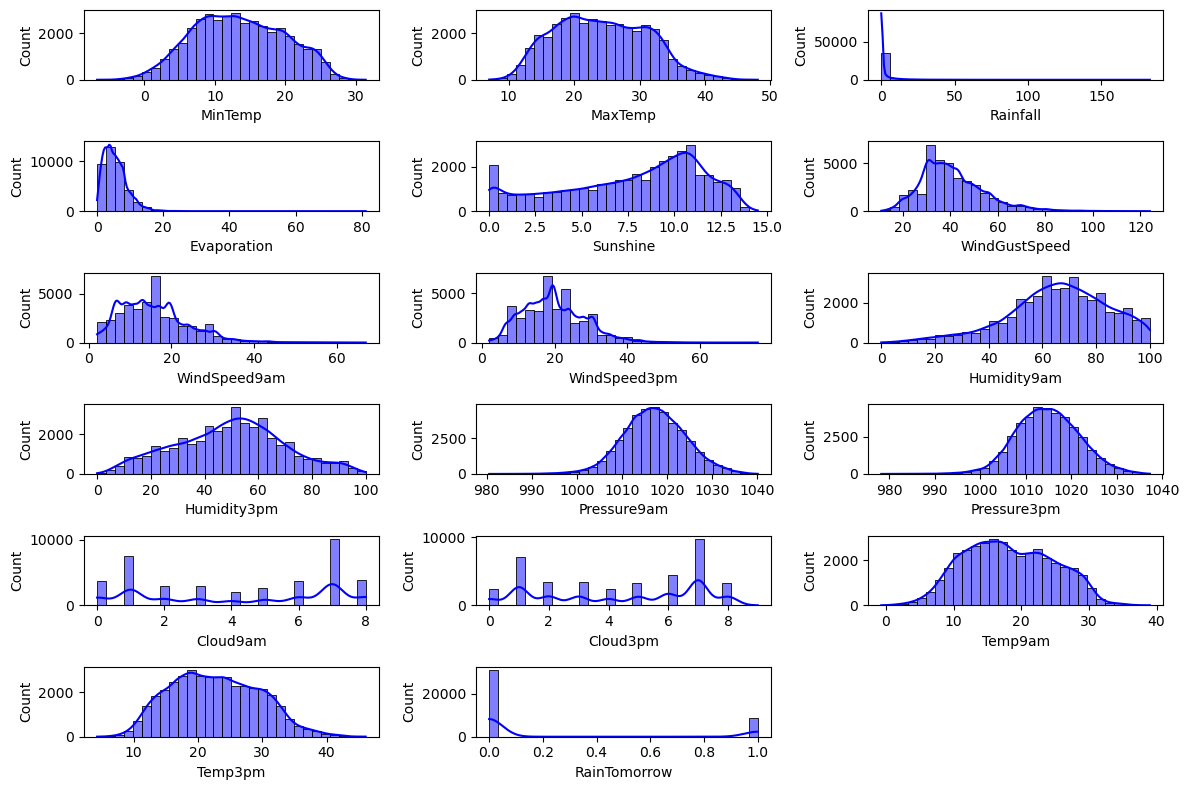

In [9]:
# Plot distributions for numerical columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, i + 1)
    sns.histplot(train_data[col], bins=30, kde=True, color='blue')
plt.tight_layout()
plt.show()

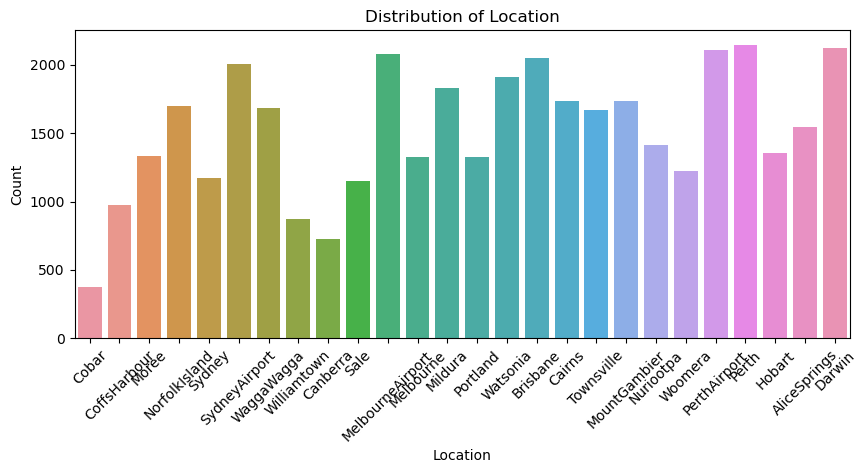

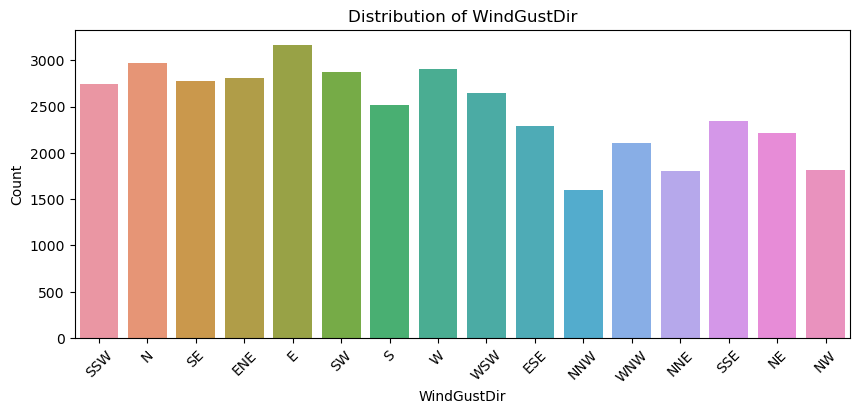

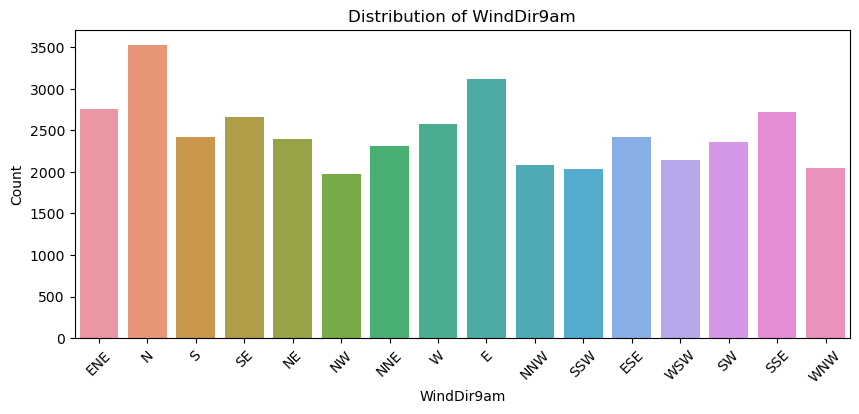

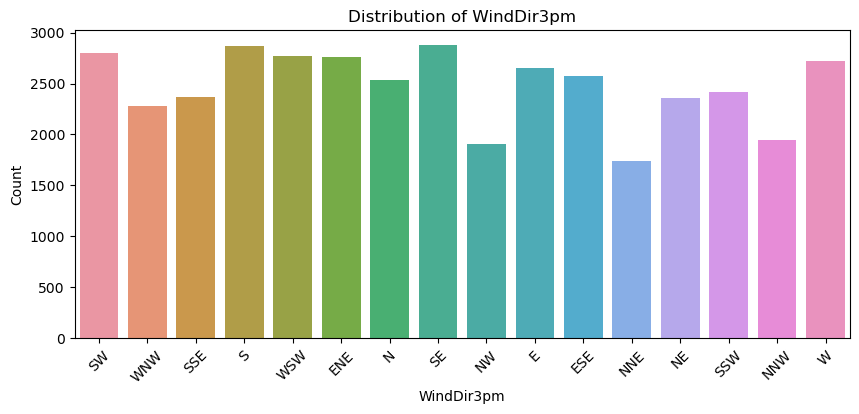

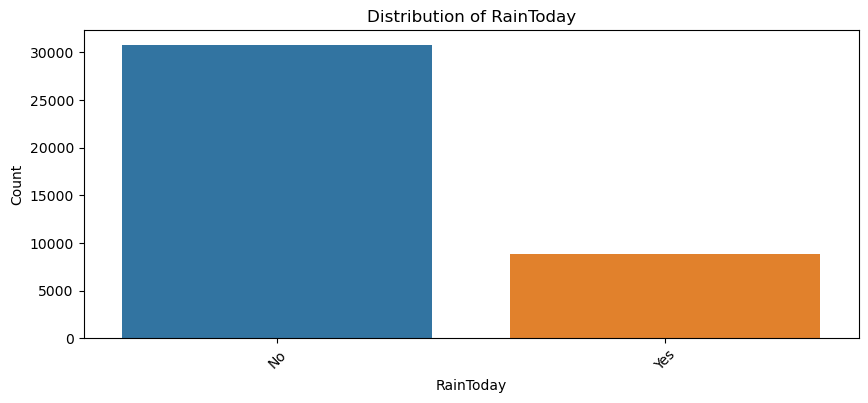

In [10]:
# Visualize distributions for categorical features
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=train_data[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)  # Set the label for the x-axis
    plt.ylabel('Count')  # Set the label for the y-axis
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
    plt.show()

In [11]:
# Create a LabelEncoder object to encode categorical columns
encoder = LabelEncoder()
for col in categorical_cols:
    train_data[col] = encoder.fit_transform(train_data[col])
train_data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
4183,4,17.9,35.2,0.0,12.0,12.3,11,48.0,1,12,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
4185,4,27.1,36.1,0.0,13.0,0.0,3,43.0,3,14,...,26.0,19.0,1007.7,1007.4,8.0,8.0,30.7,34.3,0,0
4186,4,23.3,34.0,0.0,9.8,12.6,11,41.0,8,10,...,33.0,15.0,1011.3,1009.9,3.0,1.0,25.0,31.5,0,0
4187,4,16.1,34.2,0.0,14.6,13.2,9,37.0,9,8,...,25.0,9.0,1013.3,1009.2,1.0,1.0,20.7,32.8,0,0
4188,4,19.0,35.5,0.0,12.0,12.3,1,48.0,1,15,...,46.0,28.0,1008.3,1004.0,1.0,5.0,23.4,33.3,0,0


In [12]:
# Apply the same encoding to the test data
for col in categorical_cols:
    test_data[col] = encoder.fit_transform(test_data[col])
test_data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
1756,4,18.4,28.9,0.0,14.8,13.0,8,37.0,10,10,...,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0
1757,4,19.4,37.6,0.0,10.8,10.6,5,46.0,5,6,...,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0
1758,4,21.9,38.4,0.0,11.4,12.2,14,31.0,14,15,...,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0
1759,4,24.2,41.0,0.0,11.2,8.4,14,35.0,7,14,...,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0
1760,4,19.7,35.5,0.0,11.0,12.7,4,41.0,5,15,...,17.0,61.0,14.0,1007.9,1005.8,1.0,5.0,24.0,33.6,0


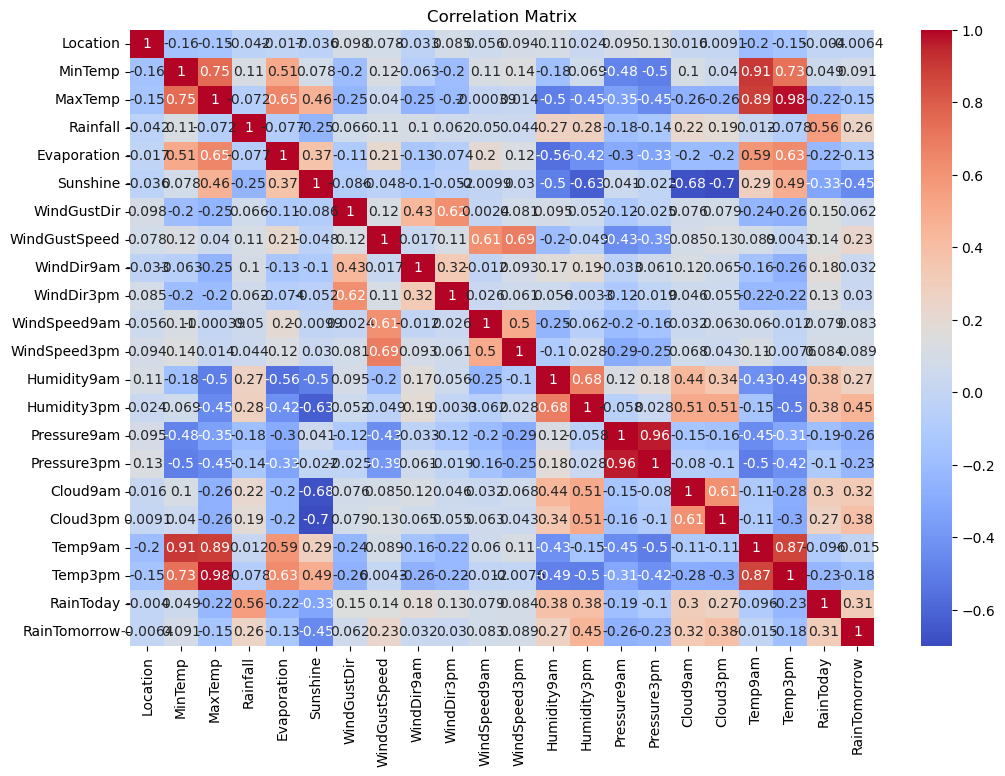

In [13]:
# Plot a correlation matrix to understand relationships between numerical features
plt.figure(figsize=(12, 8))
corr_matrix = train_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [14]:
# Identify feature columns and target column
feature_columns = train_data.columns[:-1]  # All columns except the last one
target_column = 'RainTomorrow'

In [15]:
# Separate features and target variable from training data
X = train_data[feature_columns]
y = train_data[target_column]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(test_data[feature_columns])

# Split the preprocessed data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the validation set using the Random Forest model
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_classification_report = classification_report(y_val, y_val_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest Classification Report:\n{rf_classification_report}")

Random Forest Accuracy: 0.8559696778269109
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6164
           1       0.75      0.52      0.62      1751

    accuracy                           0.86      7915
   macro avg       0.81      0.74      0.76      7915
weighted avg       0.85      0.86      0.85      7915



In [17]:
# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the validation set using the XGBoost model
y_val_pred_xgb = xgb_model.predict(X_val)

# Evaluate the XGBoost model
xgb_accuracy = accuracy_score(y_val, y_val_pred_xgb)
xgb_classification_report = classification_report(y_val, y_val_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy}")
print(f"XGBoost Classification Report:\n{xgb_classification_report}")

XGBoost Accuracy: 0.8614024005053695
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6164
           1       0.73      0.60      0.66      1751

    accuracy                           0.86      7915
   macro avg       0.81      0.77      0.79      7915
weighted avg       0.86      0.86      0.86      7915



In [36]:


# Define privileged and unprivileged groups
privileged_locations = [0, 1, 2, 3]  # Assuming these locations are encoded as 0, 1, 2, 3
unprivileged_groups = [{'Location': i} for i in range(4, len(categorical_cols))]
privileged_groups = [{'Location': i} for i in privileged_locations]

# Create a BinaryLabelDataset
train_data_aif = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([X, y], axis=1),
    label_names=['RainTomorrow'],
    protected_attribute_names=['Location']
)

# Split the BinaryLabelDataset into train and validation sets
train_data_aif, val_data_aif = train_data_aif.split([0.8], shuffle=True)

# Measure Bias in the dataset before any mitigation
metric_orig_train = BinaryLabelDatasetMetric(
    train_data_aif, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print(f"Disparate Impact before mitigation: {metric_orig_train.disparate_impact()}")
print(f"Statistical Parity Difference before mitigation: {metric_orig_train.statistical_parity_difference()}")



Disparate Impact before mitigation: 0.600736381409843
Statistical Parity Difference before mitigation: -0.08224440065090644


In [37]:
# Apply Reweighing to mitigate bias in the training data
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train_data_transf = RW.fit_transform(train_data_aif)

# Train Random Forest on reweighed data
X_train_transf = train_data_transf.features
y_train_transf = train_data_transf.labels.ravel()

rf_model = RandomForestClassifier()
rf_model.fit(X_train_transf, y_train_transf)

# Predict on the validation set and evaluate the reweighed Random Forest model
X_val = val_data_aif.features
y_val = val_data_aif.labels.ravel()

y_val_pred_rf_transf = rf_model.predict(X_val)
rf_accuracy_transf = accuracy_score(y_val, y_val_pred_rf_transf)
rf_classification_report_transf = classification_report(y_val, y_val_pred_rf_transf)

print(f"Reweighed Random Forest Accuracy: {rf_accuracy_transf}")
print(f"Reweighed Random Forest Classification Report:\n{rf_classification_report_transf}")



Reweighed Random Forest Accuracy: 0.8612760581174984
Reweighed Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      6188
         1.0       0.76      0.53      0.63      1727

    accuracy                           0.86      7915
   macro avg       0.82      0.74      0.77      7915
weighted avg       0.85      0.86      0.85      7915



In [38]:
# Measure Bias in the reweighted training dataset
metric_transf_train = BinaryLabelDatasetMetric(
    train_data_transf, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

disparate_impact_train_after = metric_transf_train.disparate_impact()
stat_parity_diff_train_after = metric_transf_train.statistical_parity_difference()

# Display the metrics in a more readable format for the training dataset
print(f"Disparate Impact in training set after mitigation: {disparate_impact_train_after:.4f}")
print(f"Statistical Parity Difference in training set after mitigation: {stat_parity_diff_train_after:.4f}")



Disparate Impact in training set after mitigation: 1.0000
Statistical Parity Difference in training set after mitigation: 0.0000
